In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms
from torchvision.utils import make_grid

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.FashionMNIST(download=True,root='../Data/',train=True,transform=transform)
test_data = datasets.FashionMNIST(download=True,root='../Data/',train=False,transform=transform)

In [55]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=512)
test_loader = DataLoader(test_data,shuffle=False,batch_size=512)

In [5]:
class_names = train_data.classes
num_classes = len(class_names)

Label: [    9     6     2     3     1     5     8     4     3     6     9     2]
Class:  Ankle boot Shirt Pullover Dress Trouser Sandal Bag Coat Dress Shirt Ankle boot Pullover


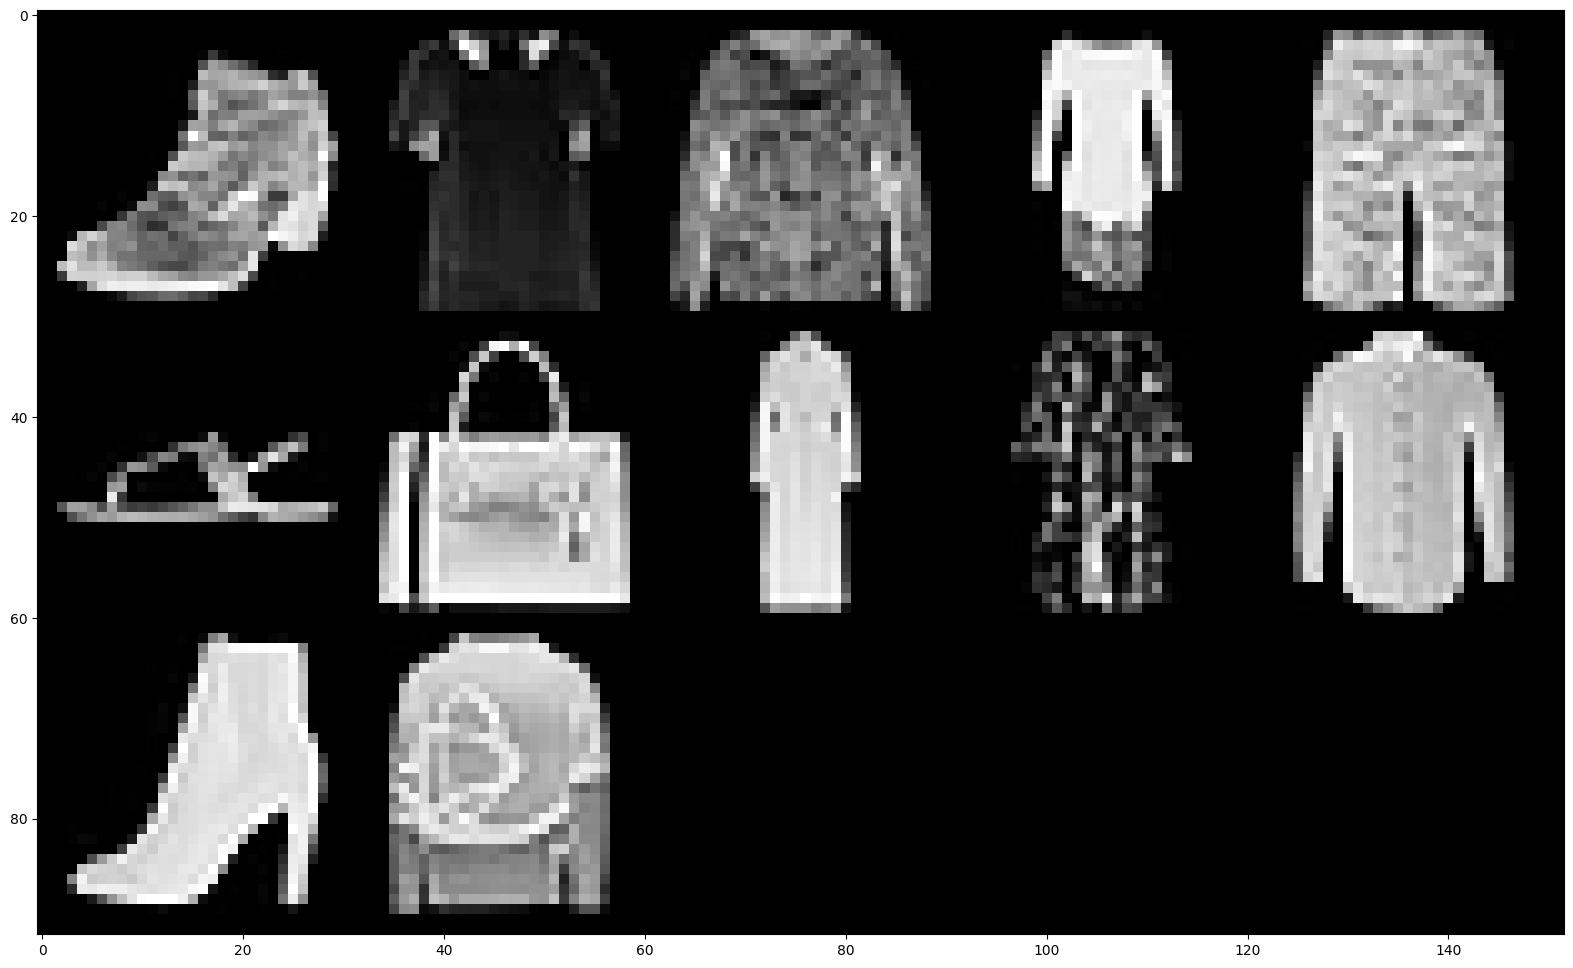

In [26]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(20,12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [7]:
def dim_calc(n_in,w_in,h_in,f,s,p,num_filters,max_pool,ms,mf):
    #(height,widht)
    if type(s) == tuple: #(2,1)
        s_h = s[0]
        s_w = s[1]
    else:
        s_h,s_w = s,s
    if type(f) == tuple:
        f_h = f[0]
        f_w = f[1]
    else:
        f_h,f_w = f,f
    if type(p) == tuple:
        p_h = p[0]
        p_w = p[1]
    else:
        p_h,p_w = p,p
        
    height = ((h_in-f_h+2*p_h)//s_h)+1
    width = ((w_in-f_w+2*p_w)//s_w)+1
    channels = num_filters
    if max_pool == True:
        height = ((height-mf)//ms)+1
        width = ((width-mf)//ms)+1
    return (channels,height,width)

In [8]:
print(f"1 : {dim_calc(1,28,28,3,1,0,6,True,2,2)}")
print(f"1 : {dim_calc(6, 13,13,3,1,0,16,True,2,2)}")

1 : (6, 13, 13)
1 : (16, 5, 5)


In [29]:
#model
#Lenet based
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(400,128)
        self.fc2 = nn.Linear(128,num_classes)
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2,2) 
        x = x.view(-1,400)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [30]:
device = torch.device("mps")
lenet = Lenet5().to(device)

In [31]:
optimizer = torch.optim.Adam(lenet.parameters(),lr=0.0005)
criterion = nn.CrossEntropyLoss()
num_epochs = 25

In [32]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    lenet.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for img, label in pbar:
        img, label  = img.to(device), label.to(device)
        optimizer.zero_grad()
        y_pred = lenet(img)
        optimizer.zero_grad()
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/25: 100%|████████████████| 118/118 [00:02<00:00, 53.80it/s, loss=0.3994]


Epoch 1/25, Average Loss: 0.8894


Epoch 2/25: 100%|████████████████| 118/118 [00:02<00:00, 57.09it/s, loss=0.4594]


Epoch 2/25, Average Loss: 0.4603


Epoch 3/25: 100%|████████████████| 118/118 [00:02<00:00, 54.36it/s, loss=0.3607]


Epoch 3/25, Average Loss: 0.3972


Epoch 4/25: 100%|████████████████| 118/118 [00:02<00:00, 57.17it/s, loss=0.3134]


Epoch 4/25, Average Loss: 0.3682


Epoch 5/25: 100%|████████████████| 118/118 [00:02<00:00, 56.50it/s, loss=0.2766]


Epoch 5/25, Average Loss: 0.3493


Epoch 6/25: 100%|████████████████| 118/118 [00:02<00:00, 56.46it/s, loss=0.3350]


Epoch 6/25, Average Loss: 0.3345


Epoch 7/25: 100%|████████████████| 118/118 [00:02<00:00, 55.37it/s, loss=0.4127]


Epoch 7/25, Average Loss: 0.3256


Epoch 8/25: 100%|████████████████| 118/118 [00:02<00:00, 56.67it/s, loss=0.2136]


Epoch 8/25, Average Loss: 0.3132


Epoch 9/25: 100%|████████████████| 118/118 [00:02<00:00, 57.73it/s, loss=0.3566]


Epoch 9/25, Average Loss: 0.3047


Epoch 10/25: 100%|███████████████| 118/118 [00:02<00:00, 57.71it/s, loss=0.2324]


Epoch 10/25, Average Loss: 0.2937


Epoch 11/25: 100%|███████████████| 118/118 [00:02<00:00, 55.84it/s, loss=0.3031]


Epoch 11/25, Average Loss: 0.2880


Epoch 12/25: 100%|███████████████| 118/118 [00:02<00:00, 57.23it/s, loss=0.2825]


Epoch 12/25, Average Loss: 0.2820


Epoch 13/25: 100%|███████████████| 118/118 [00:02<00:00, 58.85it/s, loss=0.2346]


Epoch 13/25, Average Loss: 0.2741


Epoch 14/25: 100%|███████████████| 118/118 [00:02<00:00, 58.45it/s, loss=0.3148]


Epoch 14/25, Average Loss: 0.2698


Epoch 15/25: 100%|███████████████| 118/118 [00:02<00:00, 50.84it/s, loss=0.1817]


Epoch 15/25, Average Loss: 0.2632


Epoch 16/25: 100%|███████████████| 118/118 [00:02<00:00, 49.82it/s, loss=0.1442]


Epoch 16/25, Average Loss: 0.2576


Epoch 17/25: 100%|███████████████| 118/118 [00:02<00:00, 47.84it/s, loss=0.3064]


Epoch 17/25, Average Loss: 0.2526


Epoch 18/25: 100%|███████████████| 118/118 [00:02<00:00, 49.93it/s, loss=0.2479]


Epoch 18/25, Average Loss: 0.2501


Epoch 19/25: 100%|███████████████| 118/118 [00:02<00:00, 49.95it/s, loss=0.3020]


Epoch 19/25, Average Loss: 0.2450


Epoch 20/25: 100%|███████████████| 118/118 [00:02<00:00, 49.91it/s, loss=0.2454]


Epoch 20/25, Average Loss: 0.2416


Epoch 21/25: 100%|███████████████| 118/118 [00:02<00:00, 49.85it/s, loss=0.2064]


Epoch 21/25, Average Loss: 0.2368


Epoch 22/25: 100%|███████████████| 118/118 [00:02<00:00, 49.84it/s, loss=0.1856]


Epoch 22/25, Average Loss: 0.2328


Epoch 23/25: 100%|███████████████| 118/118 [00:02<00:00, 49.53it/s, loss=0.3451]


Epoch 23/25, Average Loss: 0.2305


Epoch 24/25: 100%|███████████████| 118/118 [00:02<00:00, 49.96it/s, loss=0.3139]


Epoch 24/25, Average Loss: 0.2289


Epoch 25/25: 100%|███████████████| 118/118 [00:02<00:00, 49.91it/s, loss=0.2138]

Epoch 25/25, Average Loss: 0.2252
Total training time: 0.92 minutes


In [33]:
from sklearn.metrics import classification_report,confusion_matrix
all_preds = []
all_labels = []

lenet.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label  = img.to(device), label.to(device)
        pred = lenet(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.82      0.84      0.83      1000
           3       0.89      0.92      0.90      1000
           4       0.83      0.81      0.82      1000
           5       0.96      0.97      0.97      1000
           6       0.70      0.70      0.70      1000
           7       0.95      0.94      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



<Axes: >

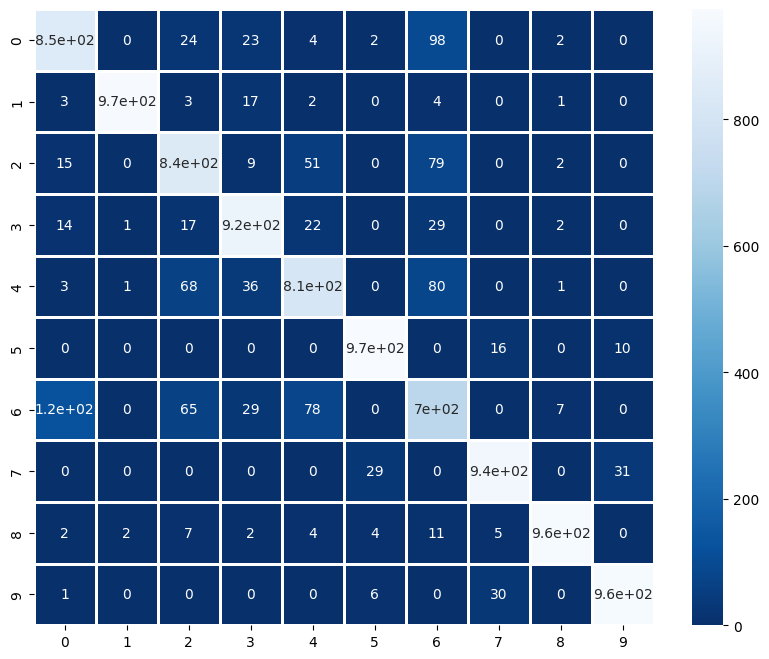

In [70]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(all_labels,all_preds),cmap='Blues_r',annot=True,linecolor='white',linewidths=1)

In [28]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### VGG inspired

In [62]:
print(f"1 : {dim_calc(1,28,28,3,1,0,4,False,0,0)}")
print(f"2 : {dim_calc(4,26,26,3,1,0,8,True,2,2)}")
print(f"3 : {dim_calc(8,12,12,3,1,0,16,False,0,0)}")
print(f"4 : {dim_calc(16,10,10,3,1,0,32,True,2,2)}")

1 : (4, 26, 26)
2 : (8, 12, 12)
3 : (16, 10, 10)
4 : (32, 4, 4)


In [79]:
#doing maxpooling every 2 conv
class VGGNet(nn.Module):
    def __init__(self,p=0.25):
        super(VGGNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1024,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,10)
        self.dropout = nn.Dropout(p)
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x,2,2)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,1024)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x,dim=1)

In [85]:
vgg = VGGNet().to(device)

In [86]:
vgg

VGGNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [87]:
num_epochs = 50
optimizer_vgg = torch.optim.Adam(vgg.parameters(),lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [91]:
from tqdm import tqdm
import time
start = time.time()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader,desc = f"{epoch+1}/{num_epochs}")
    total_loss = 0
    for img,label in pbar:
        img,label = img.to(device),label.to(device)
        y_pred = vgg(img)
        loss = criterion(y_pred,label)
        optimizer_vgg.zero_grad()
        loss.backward()
        optimizer_vgg.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")
    
        

1/50: 100%|██████████████████████| 118/118 [00:02<00:00, 40.02it/s, loss=0.0553]


Epoch 1/50, Average Loss: 0.0331


2/50: 100%|██████████████████████| 118/118 [00:02<00:00, 42.64it/s, loss=0.0242]


Epoch 2/50, Average Loss: 0.0248


3/50: 100%|██████████████████████| 118/118 [00:02<00:00, 42.61it/s, loss=0.0401]


Epoch 3/50, Average Loss: 0.0280


4/50: 100%|██████████████████████| 118/118 [00:02<00:00, 46.12it/s, loss=0.0242]


Epoch 4/50, Average Loss: 0.0172


5/50: 100%|██████████████████████| 118/118 [00:02<00:00, 47.19it/s, loss=0.0102]


Epoch 5/50, Average Loss: 0.0158


6/50: 100%|██████████████████████| 118/118 [00:02<00:00, 47.09it/s, loss=0.0085]


Epoch 6/50, Average Loss: 0.0166


7/50: 100%|██████████████████████| 118/118 [00:02<00:00, 47.25it/s, loss=0.0055]


Epoch 7/50, Average Loss: 0.0125


8/50: 100%|██████████████████████| 118/118 [00:02<00:00, 44.25it/s, loss=0.0031]


Epoch 8/50, Average Loss: 0.0205


9/50: 100%|██████████████████████| 118/118 [00:03<00:00, 39.09it/s, loss=0.0007]


Epoch 9/50, Average Loss: 0.0081


10/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.79it/s, loss=0.0122]


Epoch 10/50, Average Loss: 0.0137


11/50: 100%|█████████████████████| 118/118 [00:02<00:00, 39.64it/s, loss=0.0165]


Epoch 11/50, Average Loss: 0.0239


12/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.75it/s, loss=0.0036]


Epoch 12/50, Average Loss: 0.0125


13/50: 100%|█████████████████████| 118/118 [00:03<00:00, 35.29it/s, loss=0.0015]


Epoch 13/50, Average Loss: 0.0091


14/50: 100%|█████████████████████| 118/118 [00:03<00:00, 37.03it/s, loss=0.0110]


Epoch 14/50, Average Loss: 0.0206


15/50: 100%|█████████████████████| 118/118 [00:02<00:00, 45.38it/s, loss=0.0060]


Epoch 15/50, Average Loss: 0.0139


16/50: 100%|█████████████████████| 118/118 [00:02<00:00, 45.35it/s, loss=0.0188]


Epoch 16/50, Average Loss: 0.0128


17/50: 100%|█████████████████████| 118/118 [00:02<00:00, 45.68it/s, loss=0.0038]


Epoch 17/50, Average Loss: 0.0113


18/50: 100%|█████████████████████| 118/118 [00:02<00:00, 45.02it/s, loss=0.0006]


Epoch 18/50, Average Loss: 0.0103


19/50: 100%|█████████████████████| 118/118 [00:02<00:00, 43.03it/s, loss=0.0325]


Epoch 19/50, Average Loss: 0.0068


20/50: 100%|█████████████████████| 118/118 [00:02<00:00, 43.48it/s, loss=0.0224]


Epoch 20/50, Average Loss: 0.0197


21/50: 100%|█████████████████████| 118/118 [00:02<00:00, 42.10it/s, loss=0.0243]


Epoch 21/50, Average Loss: 0.0161


22/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.07it/s, loss=0.0016]


Epoch 22/50, Average Loss: 0.0107


23/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.63it/s, loss=0.0068]


Epoch 23/50, Average Loss: 0.0150


24/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.65it/s, loss=0.0421]


Epoch 24/50, Average Loss: 0.0133


25/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.32it/s, loss=0.0029]


Epoch 25/50, Average Loss: 0.0114


26/50: 100%|█████████████████████| 118/118 [00:03<00:00, 36.41it/s, loss=0.0016]


Epoch 26/50, Average Loss: 0.0116


27/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.80it/s, loss=0.0005]


Epoch 27/50, Average Loss: 0.0046


28/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.71it/s, loss=0.0018]


Epoch 28/50, Average Loss: 0.0043


29/50: 100%|█████████████████████| 118/118 [00:03<00:00, 37.17it/s, loss=0.0006]


Epoch 29/50, Average Loss: 0.0121


30/50: 100%|█████████████████████| 118/118 [00:03<00:00, 37.81it/s, loss=0.0315]


Epoch 30/50, Average Loss: 0.0113


31/50: 100%|█████████████████████| 118/118 [00:03<00:00, 36.28it/s, loss=0.0012]


Epoch 31/50, Average Loss: 0.0161


32/50: 100%|█████████████████████| 118/118 [00:03<00:00, 36.20it/s, loss=0.0033]


Epoch 32/50, Average Loss: 0.0079


33/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.40it/s, loss=0.0361]


Epoch 33/50, Average Loss: 0.0119


34/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.93it/s, loss=0.0050]


Epoch 34/50, Average Loss: 0.0165


35/50: 100%|█████████████████████| 118/118 [00:03<00:00, 37.65it/s, loss=0.0175]


Epoch 35/50, Average Loss: 0.0112


36/50: 100%|█████████████████████| 118/118 [00:03<00:00, 36.95it/s, loss=0.0393]


Epoch 36/50, Average Loss: 0.0105


37/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.22it/s, loss=0.0013]


Epoch 37/50, Average Loss: 0.0080


38/50: 100%|█████████████████████| 118/118 [00:03<00:00, 35.58it/s, loss=0.0375]


Epoch 38/50, Average Loss: 0.0098


39/50: 100%|█████████████████████| 118/118 [00:03<00:00, 37.14it/s, loss=0.0121]


Epoch 39/50, Average Loss: 0.0161


40/50: 100%|█████████████████████| 118/118 [00:03<00:00, 37.85it/s, loss=0.0076]


Epoch 40/50, Average Loss: 0.0071


41/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.03it/s, loss=0.0336]


Epoch 41/50, Average Loss: 0.0117


42/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.19it/s, loss=0.0002]


Epoch 42/50, Average Loss: 0.0086


43/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.79it/s, loss=0.0001]


Epoch 43/50, Average Loss: 0.0054


44/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.64it/s, loss=0.0059]


Epoch 44/50, Average Loss: 0.0053


45/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.40it/s, loss=0.1230]


Epoch 45/50, Average Loss: 0.0123


46/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.39it/s, loss=0.0003]


Epoch 46/50, Average Loss: 0.0162


47/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.02it/s, loss=0.0360]


Epoch 47/50, Average Loss: 0.0060


48/50: 100%|█████████████████████| 118/118 [00:03<00:00, 36.82it/s, loss=0.0014]


Epoch 48/50, Average Loss: 0.0125


49/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.49it/s, loss=0.0005]


Epoch 49/50, Average Loss: 0.0070


50/50: 100%|█████████████████████| 118/118 [00:03<00:00, 38.69it/s, loss=0.0032]

Epoch 50/50, Average Loss: 0.0087
Total training time: 2.48 minutes


In [93]:
from sklearn.metrics import classification_report,confusion_matrix
all_preds = []
all_labels = []

vgg.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label  = img.to(device), label.to(device)
        pred = vgg(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1000
           1       1.00      0.98      0.99      1000
           2       0.85      0.90      0.87      1000
           3       0.91      0.91      0.91      1000
           4       0.86      0.87      0.87      1000
           5       0.98      0.98      0.98      1000
           6       0.74      0.74      0.74      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.99      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [90]:
torch.save(vgg.state_dict,"Fmisnt_vgg_4_50.pth")